# Кластеризация и снижение размерности



Мы будем работать с относительно простым датасетом по ирисам Фишера. Загрузить данные можно кодом из ячейки ниже прямо из библиотеки sklearn.

\* Для желающих попробовать датасет посложнее, рекомендую скачать с Kaggle [данные](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset) по пациентам с сердечно-сосудистыми заболеваниями. Предобработку выполните самостоятельно. Можно опираться на следующий [ноутбук](https://www.kaggle.com/code/sulianova/eda-cardiovascular-data/notebook)

In [ ]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score

In [ ]:
iris_df = load_iris(as_frame=True)["frame"]
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [ ]:
species_names = load_iris()["target_names"]
species_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [ ]:
iris_df["target"] = species_names[iris_df["target"]]
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Эти данные содержат информацию по длине и ширине чашелистиков (sepal) и листков (petal) ирисов 3 видов. Ваша задача – исследовать эти данные и посмотреть как на них себя ведут разные алгоритмы кластеризации. Звёздочками обозначены не обязательные задачи. Использовать столбец "target" для кластеризации и снижения размерности **не нужно**. Мы будем сравнивать, способны ли алгоритмы воспроизвести "человеческую" классификацию цветов.


1. **Подумайте, нужно ли преобразовывать числовые данные? Проверьте, имеют ли они одинаковый масштаб, и примите решение о предобработке или обоснуйте, почему можно этого не делать**

    \* Создайте датафреймы с предобработкой и без, сравните результаты в последующих заданиях

2. **Кластеризуйте данные при помощи разных алгоритмов:**
- K-means (`sklearn.cluster.KMeans`). Используйте количество кластеров равное 3, так как мы предполагаем 3 вида в данных

    - \* Запустите алгоритм с разным значением K, посчитайте silhouette score (`sklearn.metrics.silhouette_score`) и определите оптимальное количество кластеров

- Иерархическая кластеризация (`sklearn.cluster.AgglomerativeClustering`)
- DBSCAN (`sklearn.cluster.DBSCAN`)
    - Попробуйте разные значения параметров `eps` (минимальное расстояние) и `min_samples` (минимальный размер кластера). Какое количетсво кластеров получается в разных случаях? Есть ли наблюдения, отмеченные как шум (кластер `-1`)?
- [Leiden](https://leidenalg.readthedocs.io/en/stable/intro.html)

3. **Сравните результат кластеризации разными методами.**
- Насколько кластеры от разных методов пересекаются?
- Насколько кластеры похожи на настоящие классы (виды ирисов из колонки `target` или наличие заболевания из колонки `cardio`)?
- Вам может пригодиться функция `pd.crosstab`

4. **Интерпретируйте результат кластеризации**. Возможные способы (попробуйте все или выберите то, что нравится):
- Посмотрите на средние значения признаков по кластерам
- Визуализируйте кластеры на точечных графиках по подходящим признакам
- Постройте распределения признаков по кластерам
- \* Запустите подходящие статистические тесты

Для примеров кода по алгоритмам кластеризации воспользуйтесь документацией [sklearn](https://scikit-learn.org/stable/modules/clustering.html#)

Вообщем случае числовые данные целесообразно предобработать. Но в данном примере масштаб данных примерно одинаков и измеряется в одних и тех же единицах.
Другое дело, что категориальный результат будет иногда предобработан в числовые индексы для удобства
В целом, алгоритмы кластеризации отлично разбивают датафрейм на три кластера. Лучше всего, на мой взгляд сработал K-Mean и AC-алгоритм, в остальных пришлось играться с параметрами, чтобы получить три кластера

In [ ]:
from sklearn.cluster import KMeans
# создадим пустой список для записи показателя WCSS (нашей ошибки)
wcss = []
# поместим признаки в целевую переменную
X = iris_df.drop('target', axis= 1 )
Y = iris_df.target

Text(0, 0.5, 'WCSS')

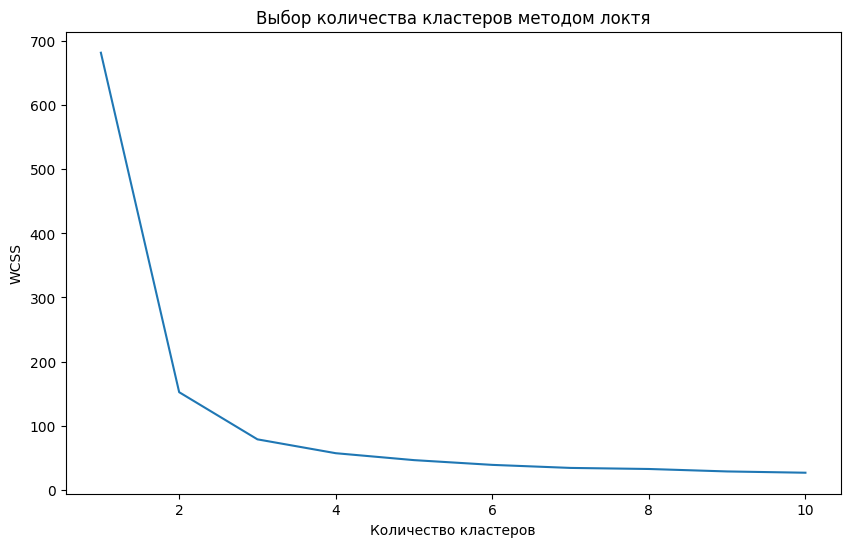

In [ ]:
# воспользуемся новой для нас функцией range(), она возвращает последовательность чисел
# в данном случае числа от 1 до 10
for i in range(1, 11):

    # настроим параметры модели (подробнее об этом расскажу чуть дальше)
    kmeans = KMeans(n_clusters = i, init = 'random', max_iter = 300, n_init = 10, random_state = 42)

    # обучим модель на наших данных с разным количеством кластеров
    kmeans.fit(X)

    # для каждого кластера рассчитаем ошибку (атрибут inertia_) и поместим в список
    wcss.append(kmeans.inertia_)

# зададим размер график
plt.figure(figsize = (10,6))
# передадим функции plot() последовательность кластеров и ошибку WCSS
plt.plot(range(1, 11), wcss)
# и добавим подписи
plt.title('Выбор количества кластеров методом локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
y_pred = kmeans.fit_predict(X)

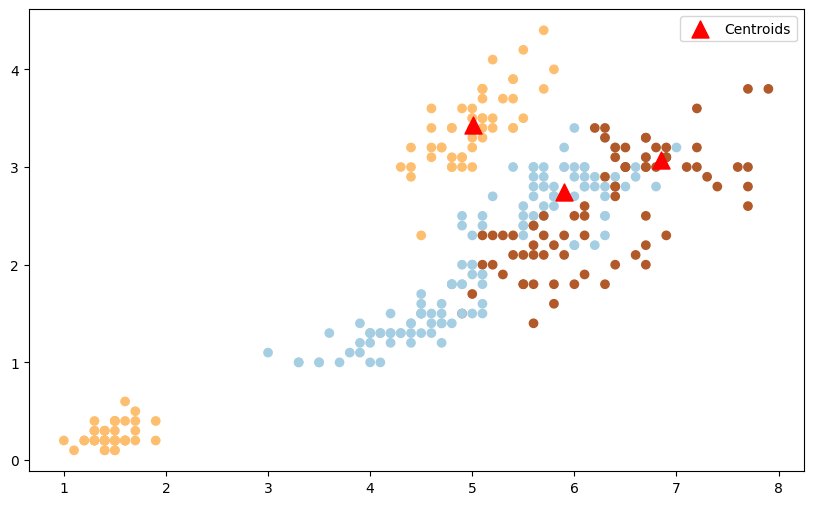

In [ ]:
plt.figure(figsize = (10,6))

# снова построим точечную диаграмму, коды точек возьмем из y_pred
plt.scatter(X.iloc[:,0], X.iloc[:,1], c = y_pred, cmap='Paired')
plt.scatter(X.iloc[:,2], X.iloc[:,3], c = y_pred, cmap='Paired')

# кроме того выведем центроиды с помощью атрибута cluster_centers_
# зададим размер s = 150, красный цвет c = 'red', тип маркера - треугольник, и подпись
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s = 150, c = 'red', marker = '^', label = 'Centroids')

# укажем, где разместить легенду
plt.legend(loc = 'upper right')

In [73]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [92]:
le = LabelEncoder()
y_enc = le.fit_transform(Y)

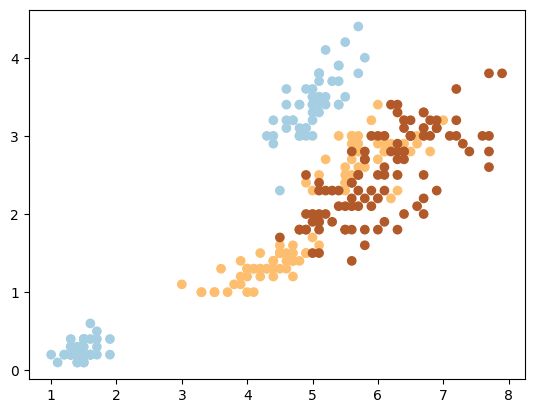

In [91]:
# Распределение данных без кластеризации

plt.scatter(X.iloc[:,0], X.iloc[:,1], c = y_enc, cmap='Paired')
plt.scatter(X.iloc[:,2], X.iloc[:,3], c = y_enc, cmap='Paired')


In [93]:
pd.crosstab(y_pred, y_enc)

col_0,0,1,2
row_0,,,
0,0,48,14
1,50,0,0
2,0,2,36


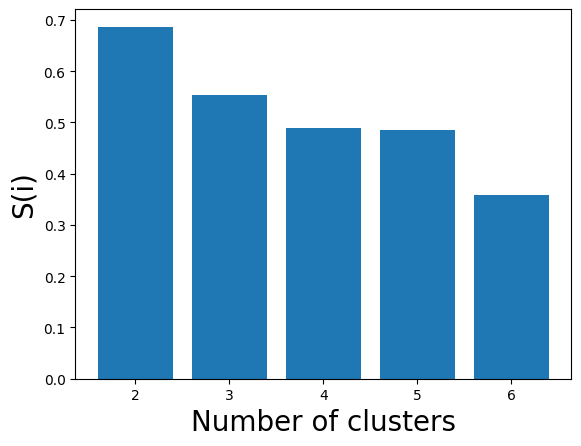

In [ ]:
k = [2, 3, 4, 5, 6]
silhouette_scores = []
for i in k:
    ac = AgglomerativeClustering(n_clusters = i)
    silhouette_scores.append(
        silhouette_score(X, ac.fit_predict(X)))

# Plotting a bar graph to compare the results
plt.bar(k, silhouette_scores)
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('S(i)', fontsize = 20)
plt.show()

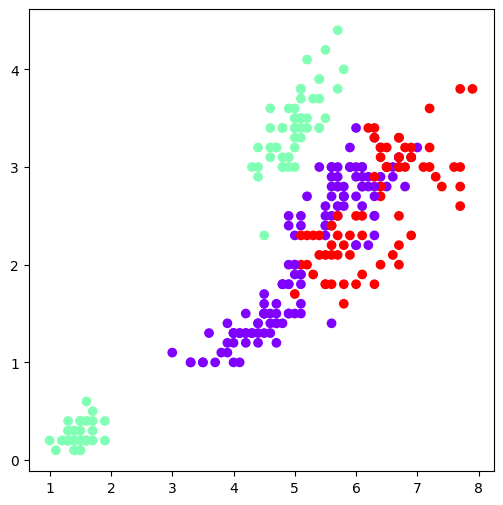

In [97]:
ac = AgglomerativeClustering(n_clusters = 3)
ac_cluster = ac.fit_predict(X)

plt.figure(figsize =(6, 6))
plt.scatter(X.iloc[:, 0], X.iloc[:,1],
           c = ac_cluster, cmap ='rainbow')
plt.scatter(X.iloc[:, 2], X.iloc[:,3],
           c = ac_cluster, cmap ='rainbow')

Estimated no. of clusters: 2
Estimated no. of noise points: 17
v_measure = 0.6044156375501386


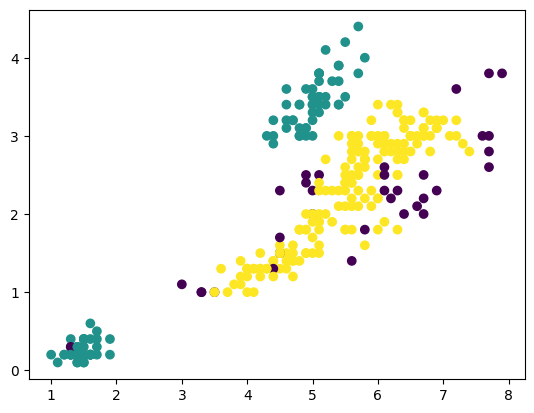

In [ ]:
dbscan_cluster1 = DBSCAN()
dbscan_cluster1.fit(X)

# Visualizing DBSCAN
plt.scatter(X.iloc[:, 0], X.iloc[:,1],
            c=dbscan_cluster1.labels_,
            label=Y)
plt.scatter(X.iloc[:, 2], X.iloc[:,3],
            c=dbscan_cluster1.labels_,
            label=Y)


# Number of Clusters
labels=dbscan_cluster1.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(dbscan_cluster1.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

# Calculating v_measure
print('v_measure =', v_measure_score(Y, labels))

Text(0, 0.5, 'Distance')

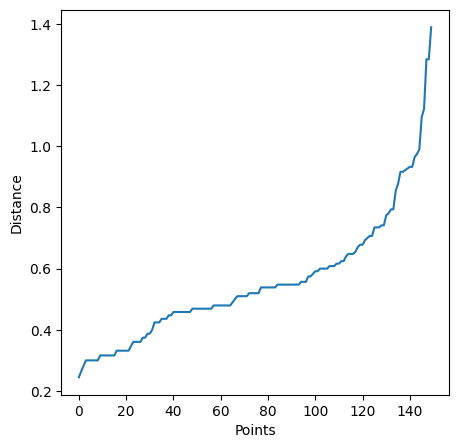

In [ ]:
from sklearn.neighbors import NearestNeighbors

nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(X)

distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:,10], axis=0)

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

Estimated no. of clusters: 3
Estimated no. of noise points: 13
v_measure = 0.6212810534211994


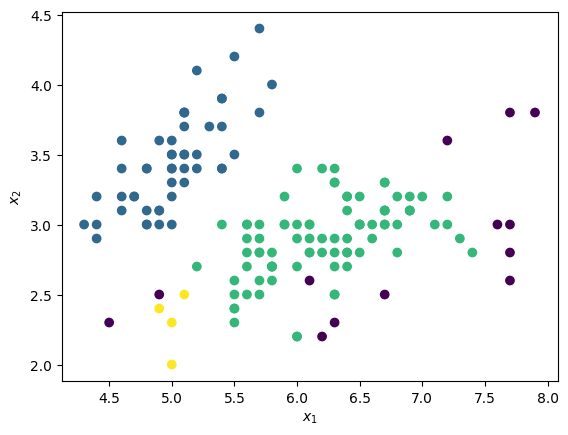

In [105]:
dbscan_cluster = DBSCAN(eps=0.5, min_samples=4)
dbscan_cluster.fit(X)

# Visualizing DBSCAN
plt.scatter(X.iloc[:, 0],X.iloc[:, 1],c=dbscan_cluster.labels_,label=Y)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

# Number of Clusters
labels=dbscan_cluster.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(dbscan_cluster.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

# Calculating v_measure
print('v_measure =', v_measure_score(Y, labels))

In [106]:
pd.crosstab(y_pred, labels)

col_0,-1,0,1,2
row_0,,,,
0,3,0,55,4
1,1,49,0,0
2,9,0,29,0


In [107]:
pd.crosstab(ac_cluster, labels)

col_0,-1,0,1,2
row_0,,,,
0,4,0,56,4
1,1,49,0,0
2,8,0,28,0


Для алгоритма leiden необходимо построить граф расстояний и пересчитать их в "похожести". На мой взгляд, удобнее всего сделать это через библиотеку для анализа данных транскриптомики scanpy. Установите её при помощи `pip install scanpy` и пользуйтесь следующей функцией:

In [ ]:

def get_leiden_clusters(data, n_neighbors: int = 15, resolution: float = 1.0):
    """Perform leiden clustering by building neighbors graph from numerical data

    Parameters
    ----------
    data : matrix or data frame
        Your data where rows are observations and columns are features. IMPORTANT:
        features must be numerical
    n_neighbors : int = 15
        Number of neighbors in KNN-graph
    resolution : float = 1.0
        Resolution parameter for leiden algorithm

    Returns
    -------
    clusters : pd.Series
        Series with clusters for your data
    """
    import scanpy as sc

    adata = sc.AnnData(data)  # Convert data to annotated data object
    sc.pp.neighbors(adata, n_neighbors=n_neighbors)  # Build neighbors graph
    sc.tl.leiden(adata, resolution=resolution)  # Run clustering
    return adata.obs["leiden"].to_numpy()

In [ ]:
!pip install leidenalg
!pip install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.1/122.1 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=82cfb56a4b6af3787bfef90623715a832817fe865d2713979809426b2fb78c23
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha2

In [ ]:
result = get_leiden_clusters(X, 75, 0.5)
result

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '2', '0', '2', '2',
       '2', '2', '0', '2', '2', '2', '2', '2', '2', '0', '0', '2', '2',
       '2', '2', '0', '2', '0', '2', '0', '2', '2', '0', '0', '2', '2',
       '2', '2', '2', '0', '2', '2', '2', '2', '0', '2', '2', '2', '0',
       '2', '2', '2', '0', '2', '2', '0'], dtype=object)

In [ ]:
install leidenalg

SyntaxError: invalid syntax (<ipython-input-19-4c55dc656a92>, line 1)

5. **Выполните понижение размерности при помощи метода PCA** (`sklearn.decomposition.PCA`)
- Визуализируйте процент объяснённой дисперсии
- Визуализируйте первые 2 компоненты
- При помощи анализа коэффициентов признаков (loadings) или визуально по графикам интерпретируйте, что означают главные компоненты для этих данных
- \* Изменяется ли результат кластеризации, если вместо исходных признаков использовать только несколько главных компонент? Сравните результат любого метода на выбор или всех

6. **Выполните визуализацию данных при помощи метода UMAP (библиотека [umap-learn](https://umap-learn.readthedocs.io/en/latest/)**
- Как на графике UMAP представлены виды цветов (или наличие заболевания для датасета по пациентам)? А отдельные признаки?
- Изменяется ли ваше понимание этих данных от этого вида визуализации? Удаётся ли обнаружить что-то необычное?

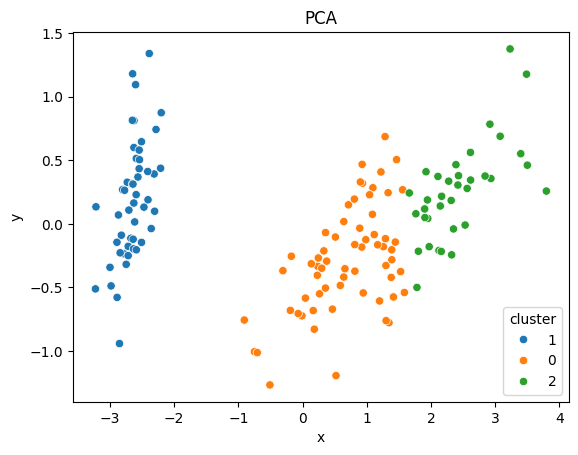

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt


pca2D = PCA(n_components=2)
#dimensions
pca_2D = pca2D.fit_transform(X)
pca2D_df = pd.DataFrame(data = pca_2D, columns = ['x', 'y'])

pca2D_df['cluster'] = result

sns.scatterplot(x='x', y='y', hue='cluster', data=pca2D_df)
plt.title("PCA")
plt.show()

In [53]:
pca2D_df

,x,y,cluster
0,-2.684126,0.319397,1
1,-2.714142,-0.177001,1
2,-2.888991,-0.144949,1
3,-2.745343,-0.318299,1
4,-2.728717,0.326755,1
...,...,...,...
145,1.944110,0.187532,2
146,1.527167,-0.375317,0
147,1.764346,0.078859,2
148,1.900942,0.116628,2


In [ ]:
!pip install umap-learn[plot]

In [63]:

Y_2 = pca2D_df.cluster
umap_data = umap.UMAP().fit(X, Y_2)

In [56]:
pip install umap-learn[plot]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 21.4 MB/s eta 0:00:00


In [57]:
import umap.plot

/usr/local/lib/python3.10/dist-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


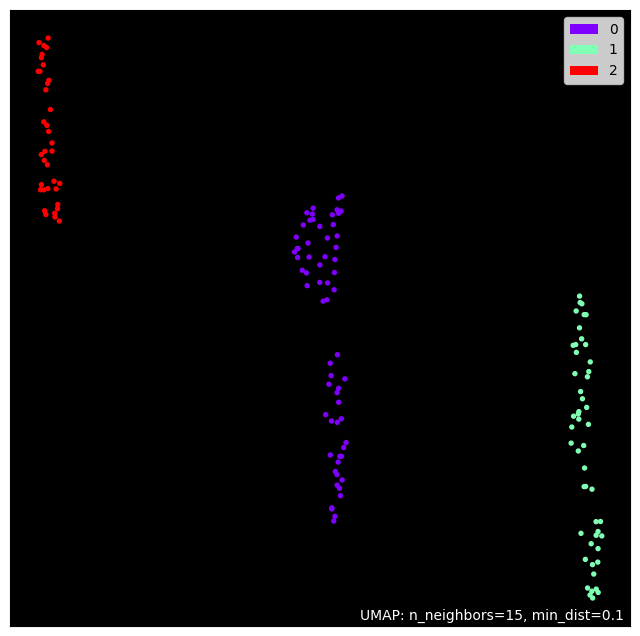

In [64]:

umap.plot.points(umap_data, labels=Y_2, theme="fire");